# Theory Beakdown
This breaks down each contribution to the theoretical scaling factor.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

2024-08-13 10:20:46,488 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/ras_conv/'
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
if 'ras_conv' in exp_dir:
    var_keep = ['temp', 'sphum', 'height']
else:
    var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [205]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
sphum_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median', 'mean_from_sphum', 'mean_from_r', 'median_from_sphum', 'median_from_r']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median', 'mean_from_sphum', 'mean_from_r', 'median_from_sphum', 'median_from_r']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
mse_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
mse_ft_sat_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        sphum_av['mean_from_sphum'][j] = ds_use.sphum[0].mean(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean_from_r'][j] = rh_use.mean(dim='lon_time')
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        mse_av['mean'][j] = mse_use[0].mean(dim='lon_time')
        mse_ft_sat_av['mean'][j] = mse_use[1].mean(dim='lon_time')
        epsilon_use = mse_use[0] - mse_use[1]
        epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
        pbar.update(1)
sphum_av['mean_from_r'] = r_av['mean_from_r'] * sphum_sat(temp_av['mean'][:, ind_surf], p_surface) 
r_av['mean_from_sphum'] = sphum_av['mean_from_sphum'] / sphum_sat(temp_av['mean'][:, ind_surf], p_surface) 

100%|██████████| 2/2 [00:20<00:00, 10.30s/it]


In [206]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
sphum_quant3_from_sphum = np.zeros((n_kappa, n_lat, n_quant))
sphum_quant3_from_r = np.zeros((n_kappa, n_lat, n_quant))
r_quant3_from_sphum = np.zeros((n_kappa, n_lat, n_quant))
r_quant3_from_r = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting
mse_quant3 = np.zeros((n_kappa, n_lat, n_quant))
mse_ft_sat_quant3 = np.zeros((n_kappa, n_lat, n_quant))
epsilon_quant3 = np.zeros((n_kappa, n_lat, n_quant))
temp_surf_mean_std = np.zeros((n_kappa, n_lat))
temp_surf_quant_std = np.zeros((n_kappa, n_lat, n_quant))

temp_ft_quant = np.zeros((n_kappa, n_lat, n_quant))             # quantile as function of ft temp not surf temp

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        epsilon_use = mse_use[0] - mse_use[1]
        if 'klzbs' in var_keep:
            is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        temp_surf_mean_std[j] = ds_use.temp[ind_surf].std(dim='lon_time')
        for q, quant in enumerate(quant_plot):
            temp_ft_quant[j, :, q] = ds_use.temp.isel(pfull=ind_ft).quantile(quant/100, dim='lon_time')
            for k in range(n_lat):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                temp_surf_quant_std[j, k, q] = ds_use.temp[ind_surf, k, use_ind].std(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3_from_sphum[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                r_quant3_from_r[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                mse_quant3[j, k, q] = mse_use[0][k, use_ind].mean(dim='lon_time')
                mse_ft_sat_quant3[j, k, q] = mse_use[1][k, use_ind].mean(dim='lon_time')
                epsilon_quant3[j, k, q] = epsilon_use[k, use_ind].mean(dim='lon_time')
                if 'klzbs' in var_keep:
                    convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
sphum_quant3_from_r = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3_from_r # compute specific humidity from relative humidity
r_quant3_from_sphum = sphum_quant3_from_sphum / sphum_sat(temp_quant3[:, ind_surf], p_surface)
# temp_anom = temp_quant3 - temp_mean[:, :, :, np.newaxis]
# epsilon_anom = epsilon_quant3 - epsilon_mean[:, :, np.newaxis]

100%|██████████| 2772/2772 [00:26<00:00, 104.75it/s]


### Median Climate
Compute median climate from `_quant3` with $x=50$

In [207]:
quant_median = 50
quant_median_ind = int(np.where(quant_plot==quant_median)[0])
temp_av['median'] = temp_quant3[:, :, :, quant_median_ind]
sphum_av['median_from_sphum'] = sphum_quant3_from_sphum[:, :, quant_median_ind]
sphum_av['median_from_r'] = sphum_quant3_from_r[:, :, quant_median_ind]
r_av['median_from_sphum'] = r_quant3_from_sphum[:, :, quant_median_ind]
r_av['median_from_r'] = r_quant3_from_r[:, :, quant_median_ind]
z_av['median'] = z_quant3[:, :, :, quant_median_ind]
mse_av['median'] = mse_quant3[:, :, quant_median_ind]
mse_ft_sat_av['median'] = mse_quant3[:, :, quant_median_ind]
epsilon_av['median'] = epsilon_quant3[:, :, quant_median_ind]

# As a function of ft quantile not surface quantile
temp_ft_median = temp_ft_quant[:, :, quant_median_ind]

## Humidity Calculation
Specific and relative humidity are related through $q_s = r_s q^*(T_s, p_s)$. When taking the mean, due to non-linear $q_s$ function, there is a difference between the value of $q_s$ when it is computed from the average of $r_s$ over all days ($r$ method) to when it is taken as the average of specific humidity on each day ($q$ method).

Below I investigate the effect of this. The difference is only apparent in the mean value, not as a function of quantile.

### Effect on MSE and $\epsilon$
At the surface, MSE is defined as $h_s = c_p T_s + L_v q_s + gz_s$. Thus it is senstive to the $q_s$ used:
* $q$ method: This is equivalent to taking $\overline{q_s}$ to be the average specific humidity for all days.
* $r$ method: Here, I compute $\overline{q_s} = \overline{r_s} q^*(\overline{T_s}, p_s)$. Where $\overline{r_s}$ is the relative humidity averaged over all days.

The $q$ method matches the simulated mean value exactly. However, we see that the $r$ method over-estimates $\overline{h}$, but it has the advantage that $\overline{r_s}$ must be less than 1 in this case (see above).

For our simulations, I think it makes sense to use the $q$ method as we always have $r<1$ anyway from tropical summer, but the $\epsilon$ effect is apparent.

In [208]:
mse_av['mean_from_sphum'] = moist_static_energy(temp_av['mean'][:, ind_surf], sphum_av['mean_from_sphum'], z_av['mean'][:, ind_surf])
mse_quant3_from_sphum = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3_from_r, z_quant3[:, ind_surf])
mse_av['mean_from_r'] = moist_static_energy(temp_av['mean'][:, ind_surf], sphum_av['mean_from_r'], z_av['mean'][:, ind_surf])
mse_quant3_from_r = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3_from_r, z_quant3[:, ind_surf])

epsilon_av['mean_from_sphum'] = mse_av['mean_from_sphum'] - mse_ft_sat_av['mean']
epsilon_quant3_from_sphum = mse_quant3_from_sphum - mse_ft_sat_quant3
epsilon_av['mean_from_r'] = mse_av['mean_from_r'] - mse_ft_sat_av['mean']
epsilon_quant3_from_r = mse_quant3_from_r - mse_ft_sat_quant3

## Average Climate
Here, give option to choose whether average climate is the mean or median through `av_use`. I recommend `'median'` i.e. conditioned on 50th percentile of near-surface temperature, as then we don't encounter the issues outlined above.

In [209]:
# Choose a humidity method - only really affects mean value
# Think probably makes sense to use 'sphum' when considering tropical summer
humidity_calc_method = 'sphum'
if humidity_calc_method == 'sphum':
    sphum_av['mean'] = sphum_av['mean_from_sphum']
    sphum_av['median'] = sphum_av['median_from_sphum']
    sphum_quant3 = sphum_quant3_from_sphum
    r_av['mean'] = r_av['mean_from_sphum']
    r_av['median'] = r_av['median_from_sphum']
    r_quant3 = r_quant3_from_sphum
elif humidity_calc_method == 'r':
    sphum_av['mean'] = sphum_av['mean_from_r']
    sphum_av['median'] = sphum_av['median_from_r']
    sphum_quant3 = sphum_quant3_from_r
    r_av['mean'] = r_av['mean_from_r']
    r_av['median'] = r_av['median_from_r']      # does not make a difference for median if from_r or from_sphum
    r_quant3 = r_quant3_from_r
    
av_use = 'median'           # recommend
# av_use = 'mean'

## Equivalence of near-surface percentile $x$ and free troposphere percentile $p$
Below, I plot $T_{FT}$ as a function of near-surface percentile, $x$, and free troposphere percentile $p$.

They clearly differ slightly with the latter being more smooth. The latter is more physically relavent as well, so it is worth obtaining a conversion between the two.

Text(0, 0.5, '$\\delta \\Delta T_{FT}$ [K]')

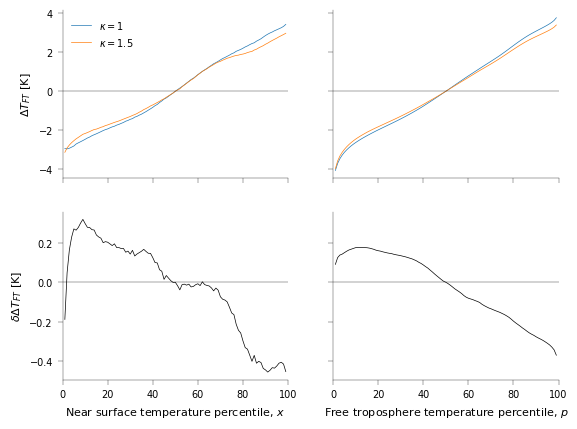

In [244]:
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey='row')
for i in range(n_kappa):
    ax[0, 0].plot(quant_plot, np.average(temp_quant3[i, ind_ft]-temp_av['median'][i, ind_ft, :, np.newaxis], weights=lat_weights, axis=0),
                  color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0, 1].plot(quant_plot, np.average(temp_ft_quant[i]-temp_ft_median[i, :, np.newaxis], weights=lat_weights, axis=0),
                  color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
ax[1, 0].plot(quant_plot, np.average(temp_quant3[1, ind_ft]-temp_av['median'][1, ind_ft, :, np.newaxis] - 
                                     (temp_quant3[0, ind_ft]-temp_av['median'][0, ind_ft, :, np.newaxis]), weights=lat_weights, axis=0),
              color='k')
ax[1, 1].plot(quant_plot, np.average(temp_ft_quant[1]-temp_ft_median[1, :, np.newaxis] - 
                                     (temp_ft_quant[0]-temp_ft_median[0, :, np.newaxis]), weights=lat_weights, axis=0), color='k')
ax[0, 0].legend()
ax[0, 0].set_xlim(0, 100)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[1, 0].set_xlabel('Near surface temperature percentile, $x$')
ax[1, 1].set_xlabel('Free troposphere temperature percentile, $p$')
ax[0, 0].set_ylabel('$\Delta T_{FT}$ [K]')
ax[1, 0].set_ylabel('$\delta \Delta T_{FT}$ [K]')

### Free troposphere percentile, $p_x$, corresponding to $x$
Below I plot compute the free troposphere, $T_{FT}(x)$ averaged over all days with near-surface temperature percentile $x$.

I then, compute the free troposphere temperature percentile $p_x$ such that the $p_x^{th}$ percentile of $T_{FT}$ (I use square bracket notation $T_{FT}[p_x]$ for this) equals $T_{FT}(x)$. I.e. $p_x$ is defined such that $T_{FT}[p_x] = T_{FT}(x)$.

I plot $p_x$ vs $x$ below. Note, $x$ runs from 1 to 99 but $p_x$ does not have to fill all these values.

In [245]:
p_x = np.zeros((n_kappa, n_lat, n_quant))
for i in range(n_kappa):
    for j in range(n_lat):
        interp_func = scipy.interpolate.interp1d(temp_ft_quant[i, j], quant_plot, fill_value='extrapolate')
        for k in range(n_quant):
            p_x[i, j, k] = interp_func(temp_quant3[i, ind_ft, j, k])

Text(0, 0.5, '$\\delta p_x$')

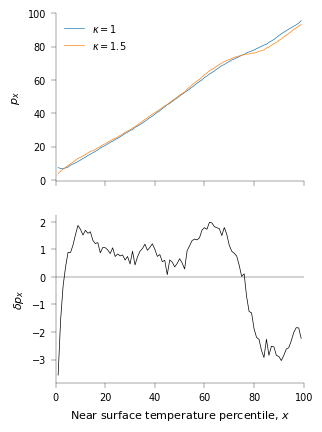

In [246]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(p_x[i], axis=0, weights=lat_weights), label=f'$\kappa={tau_lw[i]}$')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].plot(quant_plot, np.average(p_x[1] - p_x[0], axis=0, weights=lat_weights), color='k')
ax[0].legend()
ax[0].set_xlim(0, 100)
ax[1].set_xlabel('Near surface temperature percentile, $x$')
ax[0].set_ylabel('$p_x$')
ax[1].set_ylabel('$\delta p_x$')

## Conversion between $\delta T_{FT}(x)$ and $\delta T_{FT}[p_x]$

As shown above, $p_x$ changes with warming, and we must take account of this when converting between $T_{FT}(x)$ and $T_{FT}[p_x]$. We do this as below:



$\begin{align}
\delta T_{FT}(x) &= T_{FT}^{hot}[p_x^{hot}] - T_{FT}^{cold}[p_x^{cold}]\\
&= T_{FT}^{hot}[p_x^{cold} + \delta p_x] - T_{FT}^{cold}[p_x^{cold}]\\
&\approx \delta T_{FT}^{cold}[p_x^{cold}] + \delta p_x \eta^{hot}(x)
\end{align}$

where cold (hot) refers to the colder (hotter) $\kappa$ simulation, and $\eta^{hot}(x) = \frac{\partial T^{hot}_{FT}}{\partial p}\bigg|_{p_x^{cold}}$

We further assume $\eta^{hot}(x) \approx \eta^{cold}(x) = \frac{\partial T^{cold}_{FT}}{\partial p}\bigg|_{p_x^{cold}}$ giving:
 
$\delta T_{FT}(x) \approx \delta T_{FT}^{cold}[p_x^{cold}] + \delta p_x \eta^{cold}(x)$

If we assume $\eta^{cold}(x)$ is the same for all $x$, this simplifies to:

$\delta T_{FT}(x) \approx \delta T_{FT}^{cold}[p_x^{cold}] + \delta p_x \overline{\eta^{cold}}$

where $\overline{\eta^{cold}} = \frac{\partial T^{cold}_{FT}}{\partial p}\bigg|_{p_{x=50}^{cold}}$ i.e. average means conditioned on median near-surface day.

Each of these three approximations works well, except for the last one for coldest percentiles.

In [247]:
temp_ft_p_x = np.zeros((n_kappa, n_lat, n_quant))
eta_x = np.zeros((n_kappa, n_lat, n_quant))
eta_mean = np.zeros(n_lat)
p_x_ind = np.round(p_x).astype(int)-1      # use kappa=1 (colder) for p_x for both simmulations in this
for j in range(n_lat):
    eta_mean[j] = np.gradient(temp_ft_quant[0, j], quant_plot)[p_x_ind[0, j, quant_median_ind]]
    # eta_mean[j] = np.polyfit(quant_plot[20:80], temp_ft_quant[0, j, 20:80], 1)[0]
    for i in range(n_kappa):
            for q in range(n_quant):
                temp_ft_p_x[i, j, q] = temp_ft_quant[i, j, p_x_ind[0, j, q]] # -1 because it is an index
                eta_x[i, j, q] = np.gradient(temp_ft_quant[i, j], quant_plot)[p_x_ind[0, j, q]]

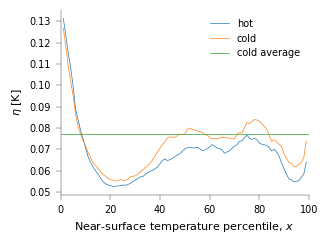

In [249]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(eta_x[1], axis=0, weights=lat_weights), color=default_colors[0], label='hot')
ax.plot(quant_plot, np.average(eta_x[0], axis=0, weights=lat_weights), color=default_colors[1], label='cold')
ax.axhline(np.average(eta_mean, axis=0, weights=lat_weights), color=default_colors[2], label='cold average')
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylabel('$\eta$ [K]')
ax.set_xlabel('Near-surface temperature percentile, $x$');

In [242]:
temp_ft_x_change_theory1 = temp_ft_p_x[1]-temp_ft_p_x[0] + eta_x[1] * (p_x[1]-p_x[0])
temp_ft_x_change_theory2 = temp_ft_p_x[1]-temp_ft_p_x[0] + eta_x[0] * (p_x[1]-p_x[0])
temp_ft_x_change_theory3 = temp_ft_p_x[1]-temp_ft_p_x[0] + eta_mean[:, np.newaxis] * (p_x[1]-p_x[0])

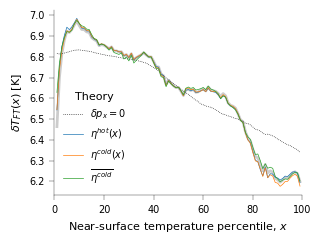

In [255]:
save_theory_fig1 = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft], axis=0, weights=lat_weights), color='k', lw=2, alpha=0.2)
ax.plot(quant_plot, np.average(temp_ft_p_x[1]-temp_ft_p_x[0], axis=0, weights=lat_weights), color='k', linestyle=':', label='$\delta p_x=0$')
ax.plot(quant_plot, np.average(temp_ft_x_change_theory1, axis=0, weights=lat_weights), color=default_colors[0], label='$\eta^{hot}(x)$')
ax.plot(quant_plot, np.average(temp_ft_x_change_theory2, axis=0, weights=lat_weights), color=default_colors[1], label='$\eta^{cold}(x)$')
ax.plot(quant_plot, np.average(temp_ft_x_change_theory3, axis=0, weights=lat_weights), color=default_colors[2], label='$\overline{\eta^{cold}}$')
ax.legend(title='Theory')
ax.set_xlim(0, 100)
ax.set_ylabel('$\delta T_{FT}(x)$ [K]')
ax.set_xlabel('Near-surface temperature percentile, $x$')

if save_fig or save_theory_fig1:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_ft_theory1_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Theory for $\delta p_x$
Above we see that given the exact value of $\delta p_x$, we can obtain a good approximation for $\delta T_{FT}(x)$. Here, we see if we can improve the theory through a theory for $\delta p_x$.

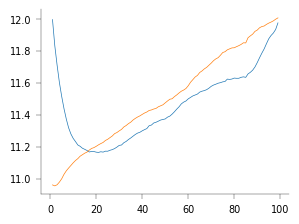

In [219]:
alpha_s = clausius_clapeyron_factor(temp_quant3[0, ind_surf], p_surface)
alpha_ft = clausius_clapeyron_factor(temp_ft_p_x[0], pressure_ft_actual)
q_sat_ft = sphum_sat(temp_ft_p_x[0], pressure_ft_actual)
q_sat_s_av = sphum_sat(temp_av[av_use][0, ind_surf], p_surface)
q_sat_s = sphum_sat(temp_quant3[0, ind_surf], p_surface)
r_s_av_change = r_av[av_use][1] - r_av[av_use][0]
epsilon_av_change = (epsilon_av[av_use][1] - epsilon_av[av_use][0]) * 1000
epsilon_x_change = (epsilon_quant3[1] - epsilon_quant3[0]) * 1000

lhs = (c_p - lnp_const + L_v * alpha_s * sphum_quant3[0]) * (temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) + (L_v * q_sat_s_av * r_s_av_change - 
                                                                                                                     epsilon_av_change)[:, np.newaxis]
rhs = (c_p + lnp_const + L_v * alpha_ft * q_sat_ft) * (temp_ft_p_x[1] - temp_ft_p_x[0])

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(lhs, axis=0, weights=lat_weights)/1000)
ax.plot(quant_plot, np.average(rhs, axis=0, weights=lat_weights)/1000)

(5.9, 7.0)

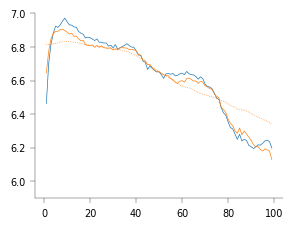

In [220]:
alpha_ft_av = clausius_clapeyron_factor(temp_av[av_use][0, ind_ft], pressure_ft_actual)
q_sat_ft_av = sphum_sat(temp_av[av_use][0, ind_ft], pressure_ft_actual)
r_s_x_change = r_quant3[1] - r_quant3[0]
beta_ft1 = c_p + lnp_const + L_v * alpha_ft_av * q_sat_ft_av
temp_ft_x_change_theory = temp_ft_p_x[1]-temp_ft_p_x[0] + 1/beta_ft1[:, np.newaxis] * (L_v * (r_s_x_change * q_sat_s - 
                                                                               (r_s_av_change * q_sat_s_av)[:, np.newaxis]) - 
                                                                        0*epsilon_x_change + 0*epsilon_av_change[:, np.newaxis])
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft], axis=0, weights=lat_weights))
ax.plot(quant_plot, np.average(temp_ft_p_x[1]-temp_ft_p_x[0], axis=0, weights=lat_weights), color=default_colors[1], linestyle=':')
ax.plot(quant_plot, np.average(temp_ft_x_change_theory, axis=0, weights=lat_weights), color=default_colors[1])
ax.set_ylim(5.9, 7)

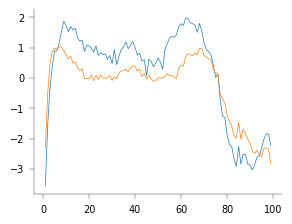

In [221]:
p_x_change_theory = 1/(beta_ft1[:, np.newaxis]*beta1) * (L_v * (r_s_x_change * q_sat_s - (r_s_av_change * q_sat_s_av)[:, np.newaxis])
                                                         - 0*epsilon_x_change + 0*epsilon_av_change[:, np.newaxis])
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(q_x[1]-q_x[0], axis=0, weights=lat_weights))
ax.plot(quant_plot, np.average(p_x_change_theory, axis=0, weights=lat_weights))

In [222]:
np.average(L_v/(beta_ft1[:, np.newaxis]*beta1) * (r_s_x_change * q_sat_s - (r_s_av_change * q_sat_s_av)[:, np.newaxis]), axis=0, weights=lat_weights)

array([-2.32287490e+00, -5.24797916e-01,  4.53629464e-01,  8.64564250e-01,
        9.74077261e-01,  9.46971793e-01,  1.02562432e+00,  1.01024320e+00,
        8.93452115e-01,  7.55472074e-01,  6.19195717e-01,  7.14223913e-01,
        4.85661593e-01,  5.22430483e-01,  3.26845143e-01,  2.41752662e-01,
        2.97928868e-01, -1.59952504e-02, -2.53189257e-02, -2.89006490e-02,
        8.69733542e-02, -9.37587290e-02,  8.43567082e-02, -5.20571116e-02,
        9.96390573e-02, -6.93104922e-04, -2.14898660e-02,  3.56437192e-03,
        6.82880112e-02, -8.46470666e-02,  2.74879374e-02, -2.57312594e-02,
        1.64555075e-01,  2.31197687e-01,  2.39777974e-01,  2.82490931e-01,
        1.91627604e-01,  3.34143445e-01,  3.79649794e-01,  3.92836950e-01,
        2.24355863e-01,  2.77817799e-01,  3.94544525e-02,  1.48860890e-01,
       -3.52495312e-02,  9.03200076e-02, -3.67585653e-02, -1.10111248e-01,
       -9.12442987e-02,  0.00000000e+00, -1.17367046e-02, -6.06439782e-04,
        4.00858365e-02,  